# Analysis of 1st Debate:2020

## Import Packages

In [1]:
import numpy as np
import pandas as pd

import math

# For vissual
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from wordcloud import WordCloud, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from collections import Counter
import datetime

## Read Data

In [2]:
df_First = pd.read_excel('Data_files/New_1st_debate.xlsx')
df_First.head()

speaker minute_parts  \
0  Chris Wallace     00:54:00   
1  Chris Wallace     02:10:00   
2      Joe Biden     02:49:00   
3   Donald Trump     02:51:00   
4      Joe Biden     02:51:00   

                                                text  minutes    minute  
0  Good evening from the Health Education Campus ...        1  00:00:54  
1  This debate is being conducted under health an...        1  00:01:34  
2                                How you doing, man?        2  00:02:13  
3                                 How are you doing?        2  00:02:15  
4                                          I’m well.        2  00:02:15

In [3]:
print(df_First.shape)

(789, 5)


## Data Processing - Convert to String

In [4]:
df_CW = df_First[df_First.speaker=='Chris Wallace']
df_CW.index = np.arange(0,len(df_CW))

df_JB = df_First[df_First.speaker=='Joe Biden']
df_JB.index = np.arange(0,len(df_JB))

df_DT = df_First[df_First.speaker=='Donald Trump']
df_DT.index = np.arange(0,len(df_DT))

In [5]:
print('Number of segments - Chris Wallace  : ', df_CW.shape[0])
print('Number of segments - Joe Biden      : ', df_JB.shape[0])
print('Number of segments - President Trump: ', df_DT.shape[0])

Number of segments - Chris Wallace  :  226
Number of segments - Joe Biden      :  249
Number of segments - President Trump:  314


In [6]:
# convert to strings

text_all = " ".join(str(txt) for txt in df_First.text)
text_CW = " ".join(txt for txt in df_CW.text)
text_JB = " ".join(txt for txt in df_JB.text)
text_DT = " ".join(txt for txt in df_DT.text)

# compare total text lengths
print('Length of text - All           : ', len(text_all))
print('Length of text - Chris Wallace : ', len(text_CW))
print('Length of text - Joe Biden     : ', len(text_JB))
print('Length of text - Donload Trump : ', len(text_DT))

Length of text - All           :  100759
Length of text - Chris Wallace :  26678
Length of text - Joe Biden     :  35336
Length of text - Donload Trump :  38743


In [7]:
# standard stopwords
my_stopwords = set(nltk.corpus.stopwords.words('english'))
# additional stopwords
my_stopwords = my_stopwords.union({"'s","'ll","'re","n't","'ve","'m"})

## Word Cloud

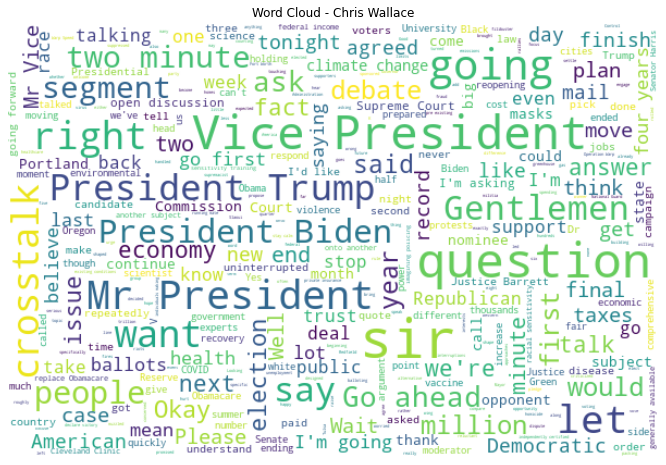

In [8]:
wordcloud = WordCloud(stopwords=my_stopwords, max_font_size=50, max_words=500,
                      width = 600, height = 400,
                      background_color="white"
                      ).generate(text_CW)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - Chris Wallace')
plt.show()

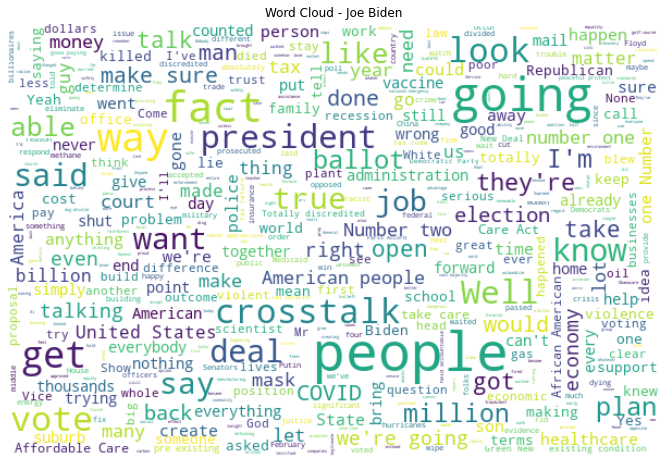

In [9]:
wordcloud = WordCloud(stopwords=my_stopwords, max_font_size=50, max_words=500,
                      width = 600, height = 400,
                      background_color="white").generate(text_JB)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - Joe Biden')
plt.show()

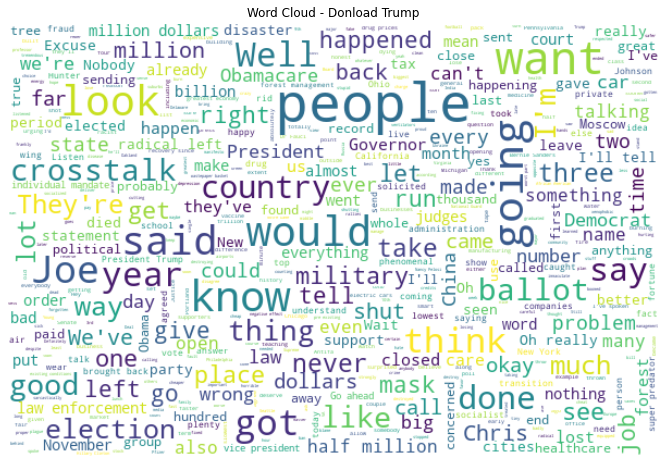

In [10]:
wordcloud = WordCloud(stopwords=my_stopwords, max_font_size=50, max_words=500,
                      width = 600, height = 400,
                      background_color="white").generate(text_DT)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - Donload Trump')

plt.show()

##  Data processing

In [11]:
# lower case
text_all = text_all.lower()
text_CW = text_CW.lower()
text_JB = text_JB.lower()
text_DT = text_DT.lower()

# tokenize text
words_all = nltk.word_tokenize(text_all)
words_CW = nltk.word_tokenize(text_CW)
words_JB = nltk.word_tokenize(text_JB)
words_DT = nltk.word_tokenize(text_DT)

# remove single characters
words_all = [word for word in words_all if len(word) > 1]
words_CW = [word for word in words_CW if len(word) > 1]
words_JB = [word for word in words_JB if len(word) > 1]
words_DT = [word for word in words_DT if len(word) > 1]

# remove stopwords
words_all = [word for word in words_all if word not in my_stopwords]
words_CW = [word for word in words_CW if word not in my_stopwords]
words_JB = [word for word in words_JB if word not in my_stopwords]
words_DT = [word for word in words_DT if word not in my_stopwords]

wordDictCW = dict.fromkeys(words_all, 0)
wordDictJB = dict.fromkeys(words_all, 0)
wordDictDT = dict.fromkeys(words_all, 0)

for word in words_CW:
    wordDictCW[word]+=1
for word in words_JB:
    wordDictJB[word]+=1
for word in words_DT:
    wordDictDT[word]+=1

In [12]:
pd.DataFrame([wordDictCW, wordDictJB, wordDictDT])

good  evening  health  education  campus  case  western  reserve  \
0     2        1       7          1       1     8        2        3   
1     8        0       2          1       0     0        0        0   
2    19        0       2          0       0     0        0        0   

   university  cleveland  ...  utah  salt  lake  nominees  mike  pence  \
0           3          3  ...     1     1     1         1     1      1   
1           0          0  ...     0     0     0         0     0      0   
2           0          0  ...     0     0     0         0     0      0   

   kamala  9:00  pm  eastern  
0       1     1   1        1  
1       0     0   0        0  
2       0     0   0        0  

[3 rows x 2154 columns]

## TFIDF

In [13]:
# finding IDF
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bowCount)
    return tfDict

def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    
    #counts the number of documents that contain a word w
    idfDict = dict.fromkeys(docList[0].keys(),0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] +=1
                
    #divide N by denominator above, take the log of that
    for word, val in idfDict.items():
        if val>0:
            idfDict[word]= math.log(N / float(val)) 

    return idfDict

def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [14]:
tfBowCW = computeTF(wordDictCW, words_CW)
tfBowJB = computeTF(wordDictJB, words_JB)
tfBowDT = computeTF(wordDictDT, words_DT)

idfs = computeIDF([wordDictCW, wordDictJB, wordDictDT])

tfidfBowCW =  computeTFIDF(tfBowCW, idfs)
tfidfBowJB = computeTFIDF(tfBowJB, idfs)
tfidfBowDT = computeTFIDF(tfBowDT, idfs)

In [15]:
First_debate_tfidf= pd.DataFrame([tfidfBowCW, tfidfBowJB,tfidfBowDT], index=['Chris Wallace', 'Joe Biden', 'Donload Trump'])
First_debate_tfidf

good   evening  health  education    campus      case  \
Chris Wallace   0.0  0.000453     0.0   0.000167  0.000453  0.003627   
Joe Biden       0.0  0.000000     0.0   0.000139  0.000000  0.000000   
Donload Trump   0.0  0.000000     0.0   0.000000  0.000000  0.000000   

                western  reserve  university  cleveland  ...      utah  \
Chris Wallace  0.000907  0.00136     0.00136    0.00136  ...  0.000453   
Joe Biden      0.000000  0.00000     0.00000    0.00000  ...  0.000000   
Donload Trump  0.000000  0.00000     0.00000    0.00000  ...  0.000000   

                   salt      lake  nominees      mike     pence    kamala  \
Chris Wallace  0.000453  0.000453  0.000453  0.000453  0.000453  0.000453   
Joe Biden      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Donload Trump  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                   9:00        pm   eastern  
Chris Wallace  0.000453  0.000453  0.000453  
Joe Biden      0.000000  0.000000  0.000000  
Donload Trump  0.000000  0.000000  0.000000  

[3 rows x 2154 columns]

## Chris Wallace: Word Frequency & Bigrams

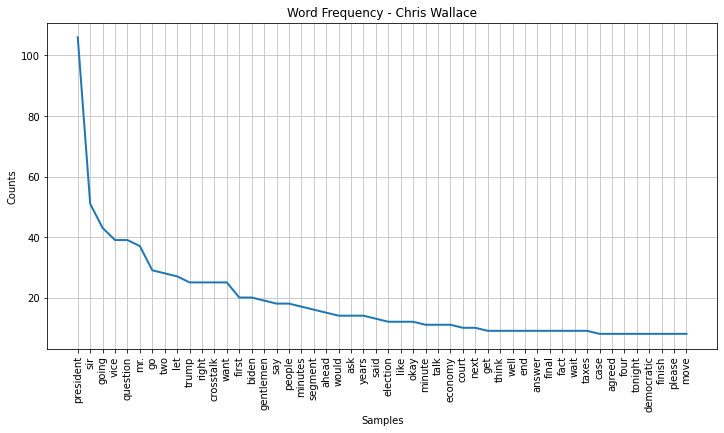

<AxesSubplot:title={'center':'Word Frequency - Chris Wallace'}, xlabel='Samples', ylabel='Counts'>

In [16]:
# count word frequencies
word_freqs = nltk.FreqDist(words_CW)
# plot word frequencies
plt.rcParams['figure.figsize'] = [12, 6]
plt.title('Word Frequency - Chris Wallace')
word_freqs.plot(50)

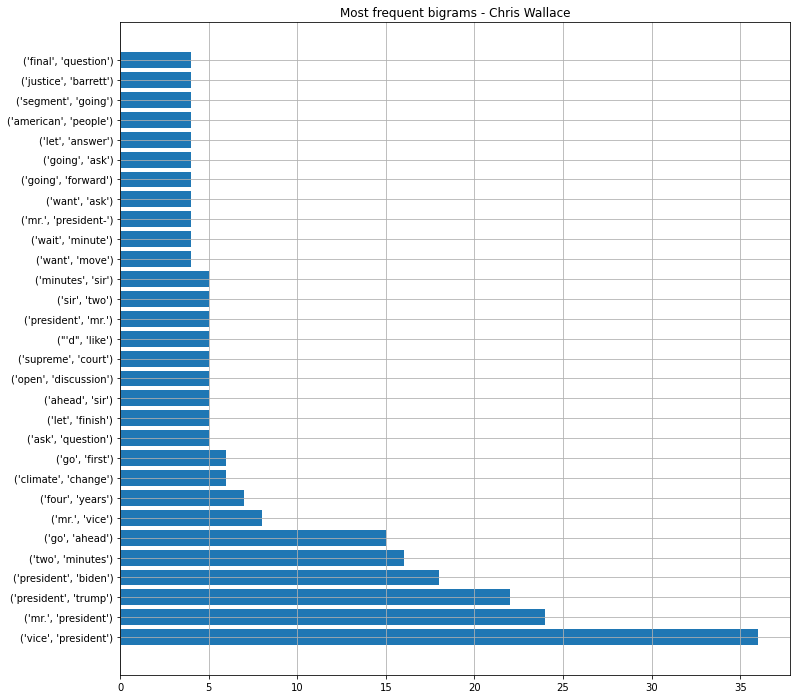

In [17]:
my_bigrams = bigrams(words_CW)
counts = Counter(my_bigrams)
counts = dict(counts)
# convert dictionary to data frame
dcounts = pd.DataFrame.from_dict(counts, orient='index', columns=['frequency'])
# select only bigrams occuring at least four times
dcounts = dcounts[dcounts.frequency>=4]
# and sort descending
dcounts = dcounts.sort_values(by='frequency', ascending=False)
plt.rcParams['figure.figsize'] = [12, 12]
plt.barh(list(map(str, dcounts.index)), dcounts.frequency)
plt.title('Most frequent bigrams - Chris Wallace')
plt.grid()
plt.show()

## Joe Biden: Word Frequency & Bigrams

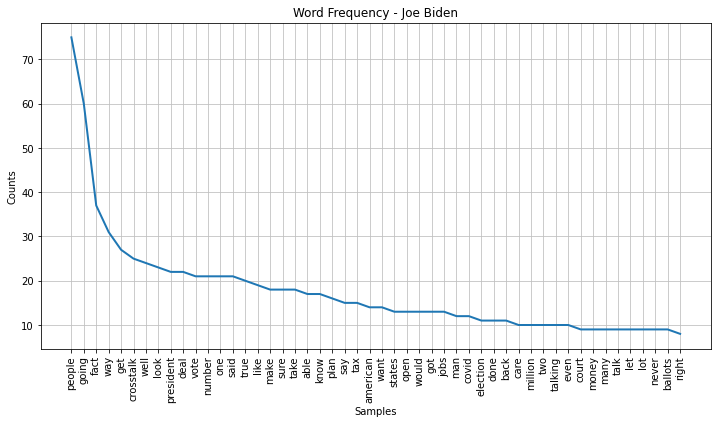

<AxesSubplot:title={'center':'Word Frequency - Joe Biden'}, xlabel='Samples', ylabel='Counts'>

In [18]:
# count word frequencies
word_freqs = nltk.FreqDist(words_JB)
# plot word frequencies
plt.rcParams['figure.figsize'] = [12, 6]
plt.title('Word Frequency - Joe Biden')
word_freqs.plot(50)

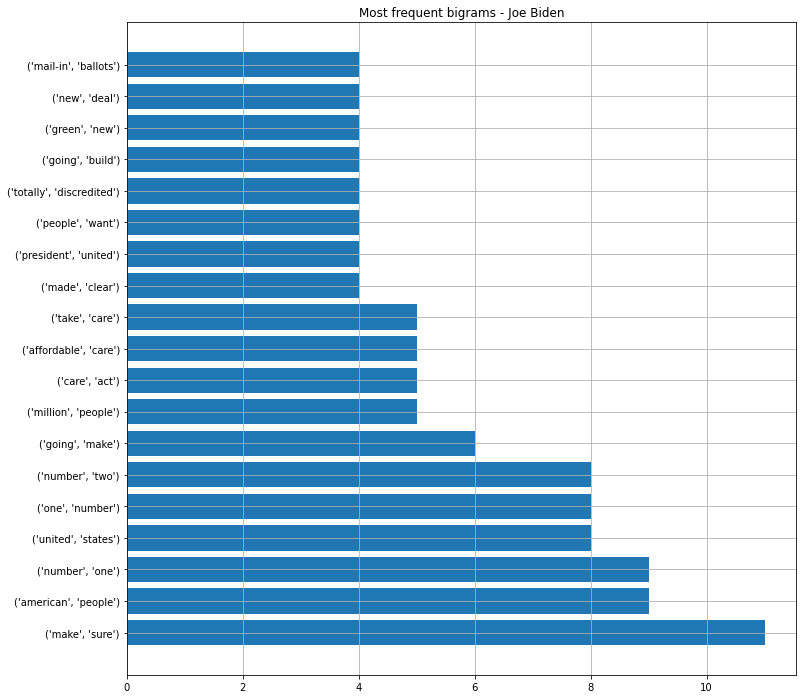

In [19]:
my_bigrams = bigrams(words_JB)
counts = Counter(my_bigrams)
counts = dict(counts)
# convert dictionary to data frame
dcounts = pd.DataFrame.from_dict(counts, orient='index', columns=['frequency'])
# select only bigrams occuring at least four times
dcounts = dcounts[dcounts.frequency>=4]
# and sort descending
dcounts = dcounts.sort_values(by='frequency', ascending=False)
plt.rcParams['figure.figsize'] = [12, 12]
plt.barh(list(map(str, dcounts.index)), dcounts.frequency)
plt.title('Most frequent bigrams - Joe Biden')
plt.grid()
plt.show()

## Donald Trump: Word Frequency & Bigrams

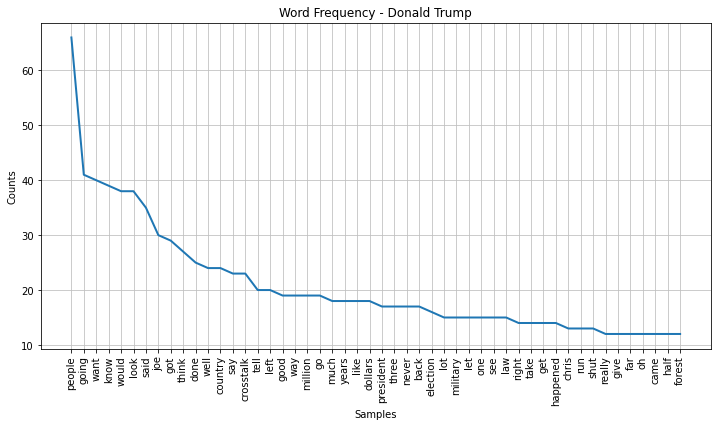

<AxesSubplot:title={'center':'Word Frequency - Donald Trump'}, xlabel='Samples', ylabel='Counts'>

In [20]:
# count word frequencies
word_freqs = nltk.FreqDist(words_DT)
# plot word frequencies
plt.rcParams['figure.figsize'] = [12, 6]
plt.title('Word Frequency - Donald Trump')
word_freqs.plot(50)

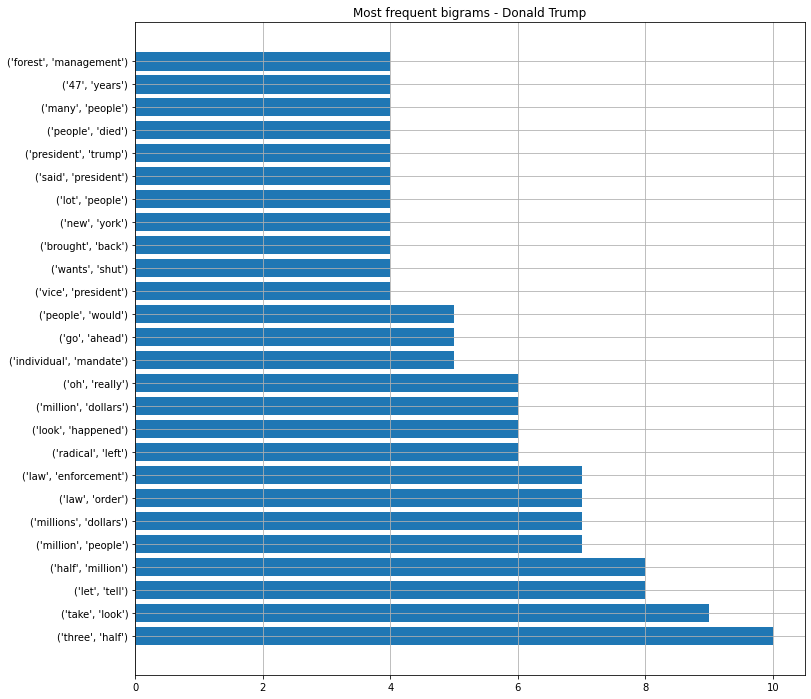

In [21]:
my_bigrams = bigrams(words_DT)
counts = Counter(my_bigrams)
counts = dict(counts)
# convert dictionary to data frame
dcounts = pd.DataFrame.from_dict(counts, orient='index', columns=['frequency'])
# select only bigrams occuring at least four times
dcounts = dcounts[dcounts.frequency>=4]
# and sort descending
dcounts = dcounts.sort_values(by='frequency', ascending=False)
plt.rcParams['figure.figsize'] = [12, 12]
plt.barh(list(map(str, dcounts.index)), dcounts.frequency)
plt.title('Most frequent bigrams - Donald Trump')
plt.grid()
plt.show()

## Heat Map

In [22]:
df_First.loc[df_First.speaker.str.contains('Chris Wallace:'), 'speaker'] = 'Chris Wallace' # correcting the typo in the name

# changing their names for more simplicity and coherence in two datasets
df_First.loc[df_First.speaker.str.contains('Vice President Joe Biden'), 'speaker'] = 'Joe Biden'
df_First.loc[df_First.speaker.str.contains('President Donald J. Trump'), 'speaker'] = 'Donald Trump'


df_First.loc[df_First.minute.isnull(), 'minute'] = '00:00'

df_First['seconds'] = 0 # we assume we start from 0
                  # and then add the values accordingly


for i, tm in enumerate(df_First.minute[1:],1):
    timeParts = [int(s) for s in str(tm).split(':')]
    
    # when we have hour like 01:10:50
    if (len(timeParts)>2) and (i<len(df_First)):
        
        current = (timeParts[0] * 60 + timeParts[1]) * 60 + timeParts[2]
        difference = current - df_First.loc[i-1, 'seconds']
        df_First.loc[i, 'seconds'] = df_First.loc[i-1, 'seconds'] + difference


df_First['minutes'] = df_First.seconds.apply(lambda x:x//60)
# We use this format of %h:%m:%s by using the following command
df_First['time'] = df_First.seconds.apply(lambda x:str(datetime.timedelta(seconds=x)))

In [23]:
# Create and show figure
heat = df_First.groupby(['minutes', 'speaker']).count().reset_index()
fig = go.Figure(data=go.Heatmap(
                z=heat.minute,
                x=heat.minutes,
                y=heat.speaker,
                colorscale='Viridis_r',
                colorbar=dict(
                title="Heat of the discussion",
                titleside="top",
                tickmode="array",
                tickvals=[1, 4, 10],
                ticktext=["very cool", "normal", "Hot!"],
                ticks="outside"
    )
        ))

fig.update_layout(title='2020 First debate: # of times each one talks in each minute',
                 xaxis_nticks=36)


fig.show()

## Sentiment Analysis

In [24]:
sia = SentimentIntensityAnalyzer()   

In [25]:
sent = sia.polarity_scores(text_CW)
sent_val = sent['compound']
sent.pop('compound')
print('Chris Wallace: sentiment score = ', sent_val)
print('Chris Wallace: split = ', sent)


Chris Wallace: sentiment score =  0.9994
Chris Wallace: split =  {'neg': 0.064, 'neu': 0.834, 'pos': 0.101}


In [26]:
sent = sia.polarity_scores(text_JB)
sent_val = sent['compound']
sent.pop('compound')
print('Joe Biden  : sentiment score = ', sent_val)
print('Joe Biden  : split = ', sent)

Joe Biden  : sentiment score =  -0.9715
Joe Biden  : split =  {'neg': 0.107, 'neu': 0.779, 'pos': 0.114}


In [27]:
sent = sia.polarity_scores(text_DT)
sent_val = sent['compound']
sent.pop('compound')
print('Donald Trump: sentiment score = ', sent_val)
print('Donald Trump: split = ', sent)

Donald Trump: sentiment score =  0.9986
Donald Trump: split =  {'neg': 0.097, 'neu': 0.786, 'pos': 0.117}
